In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader

# DATASET CREATION
class earthquake_dataset(Dataset):
    def __init__(self, Dataframe):
        self.dataframe = Dataframe
        self.labels = self.dataframe.index
        
    def __len__(self):
        return len(self.dataframe.index)

    def __getitem__(self, index):
        single_label = self.labels[index]
        features = self.dataframe.iloc[index].values.reshape(1, -1)
        features_as_tensor = torch.tensor(features).float().cuda()
        return(features_as_tensor, single_label)

In [2]:
labels = pd.read_csv('train_labels.csv')
values = pd.read_csv('train_values.csv')

data = pd.merge(labels, values)

for col_name in data.columns:
    if(data[col_name].dtype != 'int64'):
        data[col_name] = data[col_name].astype('category')
        data[col_name] = data[col_name].cat.codes
        
data["damage_grade"]-=1 


############ Untouched Data ################
trainlen = int(4 * data.shape[0] / 5)
data = data.sample(frac=1)
traindf = data[:trainlen]
testdf = data[trainlen:]

traindf = traindf.drop(['building_id'], axis=1)
testdf = testdf.drop(['building_id'], axis=1)

traindf = traindf.set_index('damage_grade')
testdf = testdf.set_index('damage_grade')

################# Normalize Data ##############
from sklearn import preprocessing

x = data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x[:, 2:])
df = pd.DataFrame(x_scaled)

df['building_id'] = x[:, 0]
df['damage_grade'] = x[:, 1]


data_norm = df[['building_id', 'damage_grade'] + [c for c in df if c not in ['building_id', 'damage_grade']]]

trainlen = int(4 * data.shape[0] / 5)

data_norm = data_norm.sample(frac=1)

traindf_norm = data_norm[:trainlen]
testdf_norm = data_norm[trainlen:]

traindf_norm = traindf_norm.drop(['building_id'], axis=1)
testdf_norm = testdf_norm.drop(['building_id'], axis=1)

traindf_norm = traindf_norm.set_index('damage_grade')
testdf_norm = testdf_norm.set_index('damage_grade')


# Features reduced.
selected_features = ['building_id', 'damage_grade', 'count_floors_pre_eq', 'position', 'roof_type', 'count_families', 'height_percentage', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'area_percentage', 'age']
data_reduced = data[selected_features]

x_reduced = data_reduced.values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_reduced = min_max_scaler.fit_transform(x_reduced[:, 2:])
df_reduced = pd.DataFrame(x_scaled_reduced)

df_reduced['building_id'] = x_reduced[:, 0]
df_reduced['damage_grade'] = x_reduced[:, 1]



data_norm_reduced = df_reduced[['building_id', 'damage_grade'] + [c for c in df_reduced if c not in ['building_id', 'damage_grade']]]

trainlen = int(4 * data.shape[0] / 5)

data_norm_reduced = data_norm_reduced.sample(frac=1)

traindf_norm_reduced = data_norm_reduced[:trainlen]
testdf_norm_reduced = data_norm_reduced[trainlen:]

traindf_norm_reduced = traindf_norm_reduced.drop(['building_id'], axis=1)
testdf_norm_reduced = testdf_norm_reduced.drop(['building_id'], axis=1)

traindf_norm_reduced = traindf_norm_reduced.set_index('damage_grade')
testdf_norm_reduced = testdf_norm_reduced.set_index('damage_grade')

In [3]:
# Initial
train_dataset = earthquake_dataset(traindf)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=512, shuffle=False)

test_dataset = earthquake_dataset(testdf)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

# Normalized
train_dataset_norm = earthquake_dataset(traindf_norm)
train_loader_norm = torch.utils.data.DataLoader(dataset=train_dataset_norm, batch_size=512, shuffle=False)

test_dataset_norm = earthquake_dataset(testdf_norm)
test_loader_norm = torch.utils.data.DataLoader(dataset=test_dataset_norm, batch_size=512, shuffle=False)

# Normalized, Reduced
train_dataset_norm_reduced = earthquake_dataset(traindf_norm_reduced)
train_loader_norm_reduced = torch.utils.data.DataLoader(dataset=train_dataset_norm_reduced, batch_size=512, shuffle=False)

test_dataset_norm_reduced = earthquake_dataset(testdf_norm_reduced)
test_loader_norm_reduced = torch.utils.data.DataLoader(dataset=test_dataset_norm_reduced, batch_size=512, shuffle=False)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_features, h1, h2, h3, h4):
        super().__init__()
        self.fc1 = nn.Linear(input_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
#         x = F.log_softmax(x, dim=1)
        return x

In [5]:
cuda = torch.device('cuda')
torch.cuda.empty_cache()
import torch.optim as optim
def Model(network, learning_rate, train_loader, test_loader):
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)
    
    costs_train = []
    costs_test = []

    for epoch in range(20):
        train_correct = 0
        total_train_loss = 0
        total_test_loss = 0
        test_correct = 0
        
        for test_batch in test_loader:
            test_features, test_labels = test_batch
            test_features = test_features.to(cuda) 
            test_labels = test_labels.to(cuda)
            test_preds = network(test_features)
            out = test_preds.squeeze()
            test_loss = F.cross_entropy(out, test_labels)
            total_test_loss += test_loss.item()

        print("Epoch: ", epoch, "\tTest Loss: ", total_test_loss)

        for train_batch in train_loader:
            train_features, train_labels = train_batch
            train_features = train_features.to(cuda)
            train_labels = train_labels.to(cuda)
            train_preds = network(train_features)
            out2 = train_preds.squeeze()
            train_loss = F.cross_entropy(out2, train_labels)


            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            total_train_loss += train_loss.item()


        print("Epoch: ", epoch, "\tTrain Loss: ", total_train_loss)


        total_train_loss /= (208480) # Train size
        total_test_loss /= (52121)   # Test size
        total_train_loss *= (100) 
        total_test_loss *= (100)
        
        costs_train.append(total_train_loss)
        costs_test.append(total_test_loss)

    Costs = [costs_train, costs_test]
    return Costs 

In [8]:
net2 = Net(38, 1024, 512, 256, 128).float().cuda()
model2_norm = Model(net2, lr, train_loader_norm, test_loader_norm)

Epoch:  0 	Test Loss:  111.04554283618927
Epoch:  0 	Train Loss:  322.9085242152214
Epoch:  1 	Test Loss:  77.89690113067627
Epoch:  1 	Train Loss:  305.89655697345734
Epoch:  2 	Test Loss:  75.67526513338089
Epoch:  2 	Train Loss:  294.8423396348953
Epoch:  3 	Test Loss:  74.58176428079605
Epoch:  3 	Train Loss:  289.3738238811493
Epoch:  4 	Test Loss:  73.45254135131836
Epoch:  4 	Train Loss:  286.00064796209335
Epoch:  5 	Test Loss:  72.42487156391144
Epoch:  5 	Train Loss:  282.8687430024147
Epoch:  6 	Test Loss:  72.12428188323975
Epoch:  6 	Train Loss:  280.0759007334709
Epoch:  7 	Test Loss:  71.82691180706024
Epoch:  7 	Train Loss:  277.35602152347565
Epoch:  8 	Test Loss:  71.71569961309433
Epoch:  8 	Train Loss:  274.76711839437485
Epoch:  9 	Test Loss:  71.77677816152573
Epoch:  9 	Train Loss:  272.32382440567017
Epoch:  10 	Test Loss:  71.9295261502266
Epoch:  10 	Train Loss:  269.86569607257843
Epoch:  11 	Test Loss:  71.90465515851974
Epoch:  11 	Train Loss:  267.39670139

In [9]:
net3 = Net(10, 1024, 512, 256, 128).float().cuda()
model3 = Model(net3, lr, train_loader_norm_reduced, test_loader_norm_reduced)

Epoch:  0 	Test Loss:  110.13332641124725
Epoch:  0 	Train Loss:  337.29870361089706
Epoch:  1 	Test Loss:  80.91053241491318
Epoch:  1 	Train Loss:  316.87439745664597
Epoch:  2 	Test Loss:  77.61951148509979
Epoch:  2 	Train Loss:  309.28545105457306
Epoch:  3 	Test Loss:  76.50563734769821
Epoch:  3 	Train Loss:  305.5203983783722
Epoch:  4 	Test Loss:  75.90556114912033
Epoch:  4 	Train Loss:  303.13223546743393
Epoch:  5 	Test Loss:  75.50982940196991
Epoch:  5 	Train Loss:  301.43562948703766
Epoch:  6 	Test Loss:  75.28406637907028
Epoch:  6 	Train Loss:  300.0244958996773
Epoch:  7 	Test Loss:  75.23155212402344
Epoch:  7 	Train Loss:  298.6513766646385
Epoch:  8 	Test Loss:  75.01553171873093
Epoch:  8 	Train Loss:  297.36230570077896
Epoch:  9 	Test Loss:  74.58301031589508
Epoch:  9 	Train Loss:  295.8434865474701
Epoch:  10 	Test Loss:  74.34524631500244
Epoch:  10 	Train Loss:  294.01879501342773
Epoch:  11 	Test Loss:  74.11993861198425
Epoch:  11 	Train Loss:  292.302482

In [12]:
import matplotlib.pyplot as plt

def plot1(loss1, loss2):
    plt.plot(np.squeeze(loss1),  color ='blue', label="Train Loss")
    plt.plot(np.squeeze(loss2),  color ='orange', label="Test Loss")
    plt.legend()

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("      Batch Size: %d, Learning Rate: %s." % (512, 0.001))
    plt.show()
    

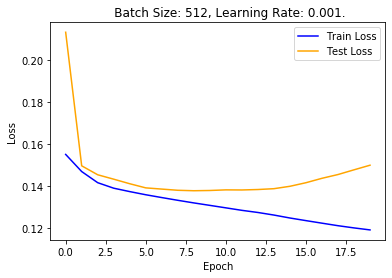

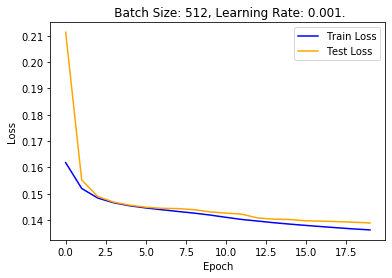

In [13]:
plot1(model2_norm[0], model2_norm[1])
plot1(model3[0], model3[1])


In [63]:


for param_tensor in net3.state_dict():
    print(param_tensor, "\t", net3.state_dict()[param_tensor])

fc1.weight 	 tensor([[-0.0995, -0.0358,  0.3006,  ..., -0.0992, -0.1323, -1.4800],
        [ 0.0946, -0.2898, -0.0640,  ..., -0.0684, -0.0215, -0.1877],
        [ 0.3593, -0.2140, -0.2047,  ..., -0.4612,  0.1876,  0.1177],
        ...,
        [-0.1617,  0.0048, -0.2336,  ..., -0.1023,  0.1550,  0.1156],
        [-0.2408,  0.1141, -0.0574,  ..., -0.3037,  0.2660, -0.2479],
        [ 0.2103,  0.2225, -0.1053,  ..., -0.0156, -0.0614,  0.0597]],
       device='cuda:0')
fc1.bias 	 tensor([-0.0582, -0.2322,  0.3796,  ...,  0.0013, -0.1124, -0.2640],
       device='cuda:0')
fc2.weight 	 tensor([[-0.0873, -0.0234, -0.1292,  ...,  0.0067,  0.0014,  0.0164],
        [ 0.0169,  0.0304,  0.0362,  ...,  0.0060,  0.0107,  0.0311],
        [ 0.0218, -0.0106, -0.0176,  ...,  0.0069, -0.0022, -0.0121],
        ...,
        [-0.0894,  0.0230, -0.1023,  ..., -0.1201, -0.0849,  0.0128],
        [-0.3658, -0.0068,  0.0846,  ...,  0.0013, -0.0160, -0.0068],
        [-0.1259,  0.0226, -0.1946,  ...,  0.0435